In [41]:
import numpy as np
import math
from scipy.fftpack import fft, ifft, dct,idct
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
import copy

840 840


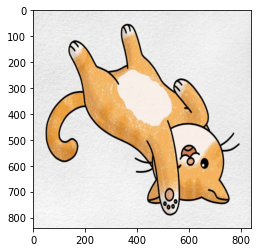

In [42]:
#загрузим на изображение, которое будем использовать в качестве контейнера
container = Image.open(r"840cat.png")
plt.imshow(container)
#mode = int(input('mode:'))
draw = ImageDraw.Draw(container)
width = container.size[0] #Определяем ширину. 
height = container.size[1] #Определяем высоту. 

print(width,height)

840 840


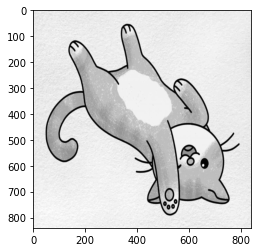

In [43]:
#подрезаем изображение %8
width=width-width%8
height=height-height%8
print(width,height)
container = container.crop((0,0,width,height))
# конвертируем в чб для получения яркости пикселей
#plt.imshow(container)
img = container.convert("L")
plt.imshow(img,cmap='gray')
pix = img.load() #Выгружаем значения пикселей.

### Подготовка стего

200 200


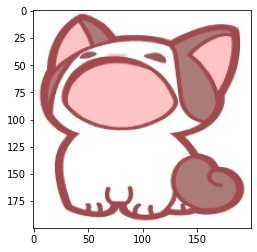

In [44]:
#загрузим изображение из которого сделаем голограмму
stego = Image.open(r"200popcat.png")#
plt.imshow(stego)
#stego=stego.convert("L")
stego_width = stego.size[0]
stego_height = stego.size[1]
stego_pix = stego.load()
print(stego_width,stego_height)
#plt.imshow(stego)

In [45]:
#делаем размер голограммы равным размеру контейнера
holo_height = height 
holo_width = width
print("Размеры матрицы для голограммы: ", holo_height, holo_width)

Размеры матрицы для голограммы:  840 840


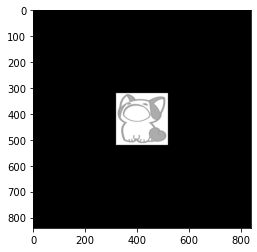

In [46]:
#задаем сдвиг голограммы
p_width = 0.5
p_height = 0.5
offset_width = (holo_width * p_width) - (stego_width // 2)
offset_height = (holo_height * p_height) - (stego_height // 2)
#нормализуем данные
holo_matrix = np.zeros((holo_height, holo_width), dtype=float)
for i in range(holo_height):
    for j in range(holo_width):
        if (j >= offset_width) and (i >= offset_height) and (i < stego_height + offset_height) and (j < stego_width + offset_width):
            holo_matrix[i][j] = stego_pix[i-offset_height, j-offset_width][0] / 255
        else:
            holo_matrix[i][j] = 0
plt.imshow(np.transpose(holo_matrix.astype(float)), cmap='gray')

In [47]:
stego_furie = dct(holo_matrix).real

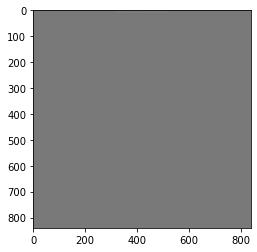

In [48]:
semiton_image = np.zeros((holo_height, holo_width), dtype=float)
#Преобразуем матрицу в полутоновое изображение
max_value = max([max(l) for l in stego_furie])
min_value = min([min(l) for l in stego_furie])
for i in range(holo_height):
    for j in range(holo_width):
        if (stego_furie[i][j] >= min_value) and (stego_furie[i][j] <= max_value):
            semiton_image[i][j] = (stego_furie[i][j] - min_value) / (max_value - min_value)
        elif (stego_furie[i][j] < min_value):
            semiton_image[i][j] = 0
        else: 
            semiton_image[i][j] = 1
plt.imshow(np.transpose((semiton_image*255).astype(int)), cmap='gray')

In [49]:
#Задаем фильтр
a = 0.2 
filter_size = 3
part_filter_size = filter_size // 2
div = 1 / (1 + a)
sq_filter = np.zeros((filter_size, filter_size), dtype=float)
sq_filter = [[-a, a-1, -a],
             [a-1, a+5, a-1],
             [-a, a-1, -a]
            ] 

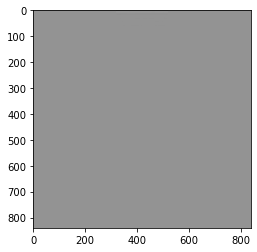

In [50]:
filtered_image = np.zeros((holo_height, holo_width), dtype=float)
#Применение фильтра
for i in range(holo_height):
    for j in range(holo_width):
        sum_elem = 0
        if (i == 0) or (j == 0) or (i == (holo_height-1)) or (j == (holo_width-1)):
            filtered_image[i][j] = semiton_image[i][j]
        else:
            temp_matr = np.zeros((filter_size, filter_size), dtype=float)
            for k in range (filter_size):
                for l in range (filter_size):
                    temp_matr[k][l] = semiton_image[i+k-1][j+l-1]
            #temp_matr = semiton_image[i:i+filter_size, j:j+filter_size]
            temp_matr = np.multiply(temp_matr, sq_filter)
            temp_matr *= div
            for k in range (filter_size):
                for l in range (filter_size):
                    sum_elem += temp_matr[k][l]
                
            filtered_image[i][j] = sum_elem
            
plt.imshow(np.transpose((filtered_image*255).astype(int)), cmap='gray')          

In [51]:
red_image = np.zeros((holo_height, holo_width), dtype=float)
#Операция, уменьшающая возмущения
gamma = 0.909

sum_pix = 0
for i in range(holo_height):
    for j in range(holo_width):
        sum_pix += filtered_image[i][j]
mean_pix = sum_pix / holo_height / holo_width    
        
for i in range(holo_height):
    for j in range(holo_width):
        red_image[i][j] = filtered_image[i][j] - mean_pix * gamma

In [52]:
print(len(stego_furie))

840


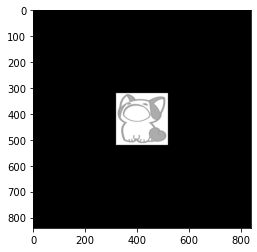

In [53]:
st = idct(stego_furie).real
plt.imshow(np.transpose(st), cmap='gray')

### Встраивание голограммы 

##### Разбиваем на блоки + DCT

In [54]:
all_pixels = []
img_stego = np.zeros((width,height), dtype=float)
for i in range(1,height//8+1):
    for j in range(1,width//8+1):
        bright_8x8=[]
        
        for k in range(i*8-8,i*8):
            for n in range(j*8-8,j*8):
                #print(k,n)
                bright_8x8.append(pix[n,k])
                img_stego[n][k]=pix[n,k]
        a=dct(bright_8x8)
        #a=idct(a)
        all_pixels.append(a)

array([[232., 223., 225., ..., 238., 241., 243.],
       [228., 226., 225., ..., 239., 241., 242.],
       [225., 229., 226., ..., 238., 241., 242.],
       ...,
       [242., 240., 241., ..., 236., 238., 237.],
       [240., 238., 239., ..., 236., 238., 238.],
       [242., 239., 242., ..., 235., 238., 238.]])

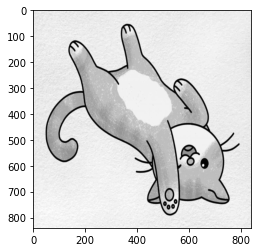

In [55]:
plt.imshow(np.transpose(img_stego), cmap='gray')
np.transpose(img_stego)

In [70]:
#определяем порог коэфициента DC
print(len(all_pixels))
sumkoef=0
for i in range(len(all_pixels)):
    sumkoef=sumkoef+all_pixels[i][0]
porog=sumkoef//(len(all_pixels)+10000000)
print(porog)
print(len(stego_furie))
print(len(all_pixels))

11025
30.0
840
11025


In [68]:
all_pix = copy.deepcopy(all_pixels)
#img_stego_copy=copy.deepcopy(img_stego)
k=0

for i in range (len(all_pixels)):
    
    if all_pixels[i][0]>=porog:
        for j in range(64):
            all_pix[i][j]=all_pix[i][j]+porog*filtered_image[k][j]
        k=k+1
    if k==len(stego_furie):
        print("caught")
        break



caught


In [58]:
i_all_pix=[]
for i in range(len(all_pix)):
    a=idct(all_pix[i])
    i_all_pix.append(a)

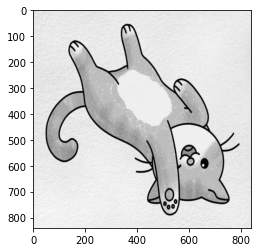

In [59]:
img_stego1 = np.zeros((height,width), dtype=float)
c=0
for i in range (1,height//8+1): 
    for j in range(1,width//8+1):
        m=0
        for k in range(i*8-8,i*8):
            for n in range(j*8-8,j*8):
                img_stego1[k][n]= i_all_pix[c][m]  
                m=m+1
        c=c+1
plt.imshow(img_stego1, cmap='gray')

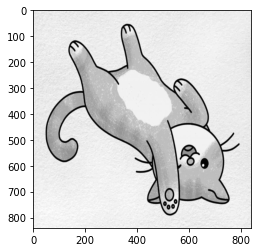

In [61]:
plt.imshow(np.transpose(img_stego), cmap='gray')

In [62]:
def align_list(a):
    img_stego = np.zeros((height,width), dtype=float)
    c=0
    for i in range (1,height//8+1): 
        for j in range(1,width//8+1):
            m=0
            for k in range(i*8-8,i*8):
                for n in range(j*8-8,j*8):
                    img_stego[k][n]= a[c][m]  
                    m=m+1
            c=c+1
    #plt.imshow(np.transpose(img_stego), cmap='gray')
    return img_stego


### Восстановление голограммы

In [63]:
#all_pix - заполненный контейнер с  ДКП
#all_pixels - чистый контейнер с ДКП
all_pix_align=align_list(all_pix)
all_pixels_align=align_list(all_pixels)

img_stego2 = np.zeros((height,width), dtype=float)

diff=[]
diff_p=[]
for i in range(height):
    for j in range(width):
        img_stego2[i][j]=(all_pix_align[i][j]-all_pixels_align[i][j])/porog




In [64]:
img_stego=np.transpose(img_stego)
img_stego3 = np.zeros((height,width), dtype=float)
for i in range(height):
    for j in range(width):
        img_stego3[i][j]=(img_stego[i][j]-img_stego1[i][j])/porog


In [65]:
recover_image=idct(img_stego3).real
            

In [66]:
for i in range(len(recover_image)):
    for j in range(len(recover_image[0])):
        if (recover_image[i][j] >=0 ):
            recover_image[i][j] *= 4
        else:
            recover_image[i][j] = 0
#plt.imshow(np.transpose(recover_image), cmap='gray')

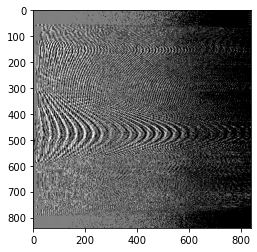

In [67]:
#Выполняем контрастирование
mean_pix = 0
sum_pix = 0
for i in range(height):
    for j in range(width ):
        sum_pix += recover_image[i][j]
        
mean_pix = (sum_pix /  height/ width/ 4 )

contrast_pict = np.zeros((height, width ), dtype=float)
for i in range(height):
    for j in range(width):
        if (recover_image[i][j] >=mean_pix ):
            contrast_pict[i][j] = 255
        else:
            contrast_pict[i][j] = 0 
plt.imshow(contrast_pict, cmap='gray')